In [1]:
# PyDESeq2 Workflow: Differential Expression
# Alternaria at 14_dpi (day 14: post innoculation)

In [2]:
## Import Necessary Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
## Load Data

In [6]:
df = pd.read_csv('combined_reads_alternaria_dpi14.csv')
df.head()

,Geneid,Alternaria_T14_1,Alternaria_T14_2,Alternaria_T14_3,Control_T14_1,Control_T14_2,Control_T14_3,Control_T14_4
0,AA0117_g585,0,4,16,0,0,0,0
1,AA0117_g1326,43,36,123,0,0,0,0
2,AA0117_g684,0,0,2,0,0,0,0
3,AA0117_g834,0,0,1,0,0,0,0
4,AA0117_g507,19,8,44,2,0,0,0


In [7]:
# set Geneid as index
data = df.set_index('Geneid')
data.head(2)

,Alternaria_T14_1,Alternaria_T14_2,Alternaria_T14_3,Control_T14_1,Control_T14_2,Control_T14_3,Control_T14_4
Geneid,,,,,,,
AA0117_g585,0,4,16,0,0,0,0
AA0117_g1326,43,36,123,0,0,0,0


In [8]:
# filter out genes and keep rows where the sum is greater than 10; then transpose
data = data[data.sum(axis = 1) > 10]
data.head(3)

,Alternaria_T14_1,Alternaria_T14_2,Alternaria_T14_3,Control_T14_1,Control_T14_2,Control_T14_3,Control_T14_4
Geneid,,,,,,,
AA0117_g585,0,4,16,0,0,0,0
AA0117_g1326,43,36,123,0,0,0,0
AA0117_g507,19,8,44,2,0,0,0


In [9]:
len(data)

5837

In [10]:
data.to_csv('filtered_read_counts.csv')

In [11]:
data = data.T
data

Geneid,AA0117_g585,AA0117_g1326,AA0117_g507,AA0117_g1239,AA0117_g1551,AA0117_g316,AA0117_g510,AA0117_g152,AA0117_g170,AA0117_g1759,...,AA0117_g13141,AA0117_g13177,AA0117_g13179,AA0117_g13259,AA0117_g13262,AA0117_g13312,AA0117_g13343,AA0117_g13357,AA0117_g13387,AA0117_g13533
Alternaria_T14_1,0,43,19,0,18,2,10,4,5,22,...,0,16,5,0,0,6,10,4,0,6
Alternaria_T14_2,4,36,8,4,12,0,30,6,2,39,...,0,16,0,1,3,9,0,5,0,0
Alternaria_T14_3,16,123,44,16,8,18,77,2,6,62,...,16,33,9,30,11,31,13,7,18,7
Control_T14_1,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Control_T14_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Control_T14_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Control_T14_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Create Metadata

In [13]:
samples = data.index.tolist()

In [14]:
metadata = pd.DataFrame({
    'Sample': samples,
    'condition': ['Treatment'] * 3 + ['Control'] * 4,
    'group': ['X', 'Y', 'X', 'Y', 'X', 'Y', 'Y']
})

metadata.set_index('Sample', inplace=True)

In [15]:
metadata

,condition,group
Sample,,
Alternaria_T14_1,Treatment,X
Alternaria_T14_2,Treatment,Y
Alternaria_T14_3,Treatment,X
Control_T14_1,Control,Y
Control_T14_2,Control,X
Control_T14_3,Control,Y
Control_T14_4,Control,Y


In [16]:
# Single Factor Analysis

In [17]:
# Initialize the DESeq2 dataset using the DeseqDataSet class
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=data,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

In [18]:
dds

AnnData object with n_obs × n_vars = 7 × 5837
    obs: 'condition', 'group'
    obsm: 'design_matrix'

In [19]:
dds.obs

,condition,group
Sample,,
Alternaria_T14_1,Treatment,X
Alternaria_T14_2,Treatment,Y
Alternaria_T14_3,Treatment,X
Control_T14_1,Control,Y
Control_T14_2,Control,X
Control_T14_3,Control,Y
Control_T14_4,Control,Y


In [20]:
dds.var

""
Geneid
AA0117_g585
AA0117_g1326
AA0117_g507
AA0117_g1239
AA0117_g1551
...
AA0117_g13312
AA0117_g13343
AA0117_g13357


In [21]:
dds.X

array([[  0,  43,  19, ...,   4,   0,   6],
       [  4,  36,   8, ...,   5,   0,   0],
       [ 16, 123,  44, ...,   7,  18,   7],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [22]:
dds.X.shape

(7, 5837)

In [23]:
# run deseq2 analysis
dds.deseq2()

Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 12.57 seconds.

Fitting dispersion trend curve...
... done in 0.85 seconds.

Fitting MAP dispersions...
... done in 11.45 seconds.

Fitting LFCs...
... done in 7.98 seconds.

Refitting 0 outliers.



In [24]:
dds

AnnData object with n_obs × n_vars = 7 × 5837
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [25]:
# Dispersions and LFCs (in natural log scale)
dds.varm["dispersions"]

array([ 6.59655689,  0.71713965,  1.23085961, ...,  3.55263686,
       10.        ,  8.22516771])

In [26]:
dds.varm["LFC"]

,intercept,condition_Treatment_vs_Control
Geneid,,
AA0117_g585,-1.392019,2.790984
AA0117_g1326,-1.392024,5.104651
AA0117_g507,-0.406309,3.076523
AA0117_g1239,-1.392019,2.790984
AA0117_g1551,-1.392024,3.426919
...,...,...
AA0117_g13312,-1.392024,3.624038
AA0117_g13343,-1.392020,2.940861
AA0117_g13357,-1.392023,2.562071


In [27]:
# Principal Component Analysis (PCA)

In [28]:
# Log-transform the counts
log_transformed = np.log2(data + 1)

In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_transformed)

In [30]:
# Create a DataFrame with PCA results and metadata
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['condition'] = metadata['condition'].values

In [31]:
# Calculate explained variance for the plot
explained_variance = pca.explained_variance_ratio_

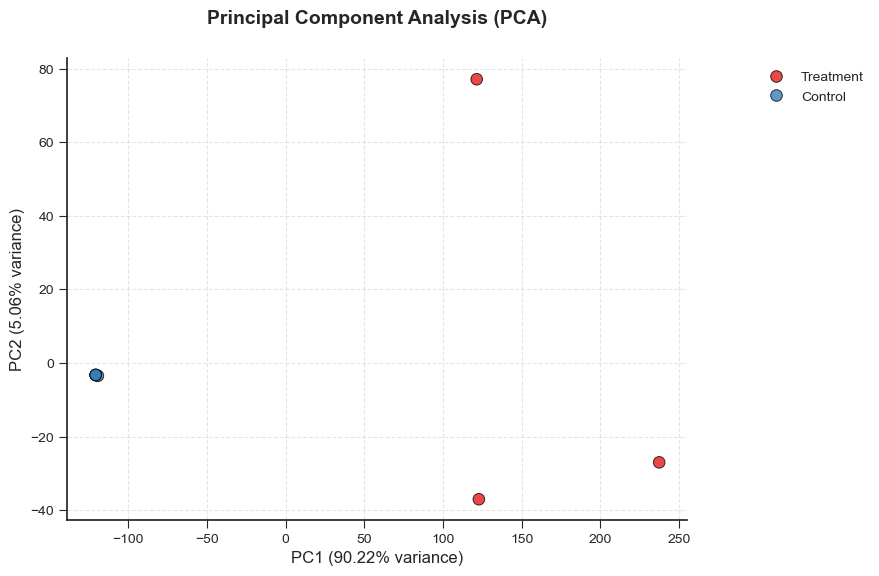

In [32]:
# Set a clean and professional style
plt.style.use('seaborn-ticks')

# Create PCA plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='condition', data=pca_df, 
    s=70, edgecolor='black', alpha=0.8, palette='Set1'
)

# Label axes with explained variance
plt.xlabel(f'PC1 ({explained_variance[0] * 100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1] * 100:.2f}% variance)', fontsize=12)

# Title and legend improvements
plt.title('Principal Component Analysis (PCA)', fontsize=14, weight='bold', pad=25)
plt.legend(title='', bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=10)

# Improve visual clarity
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()  # Removes unnecessary borders

# Save figure in high resolution
plt.savefig('PCA_alternaria_14dpi.png', dpi=600, bbox_inches='tight')
plt.show()

In [33]:
# Statistical Analysis with the DeseqStats class

In [34]:
stat_res = DeseqStats(dds, inference=inference)

In [35]:
# Wald Test
stat_res.summary()

Running Wald tests...
... done in 2.53 seconds.



Log2 fold change & Wald test p-value: condition Treatment vs Control
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                   
AA0117_g585     1.736439        4.026539  3.310059  1.216455  0.223811   
AA0117_g1326   17.557861        7.364455  1.897538  3.881057  0.000104   
AA0117_g507     6.511964        4.438484  1.602044  2.770514  0.005597   
AA0117_g1239    1.736439        4.026539  3.310059  1.216455  0.223811   
AA0117_g1551    3.279410        4.943999  2.226797  2.220229  0.026403   
...                  ...             ...       ...       ...       ...   
AA0117_g13312   3.994711        5.228381  2.258724  2.314750  0.020627   
AA0117_g13343   2.017631        4.242765  3.161773  1.341894  0.179630   
AA0117_g13357   1.381041        3.696288  2.691398  1.373371  0.169637   
AA0117_g13387   1.579016        3.889254  3.889390  0.999965  0.317327   
AA0117_g13533   1.140400        3.419506  3

In [36]:
# Expressed genes
res = stat_res.results_df
res.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
AA0117_g585,1.736439,4.026539,3.310059,1.216455,0.223811,NaN
AA0117_g1326,17.557861,7.364455,1.897538,3.881057,0.000104,0.000886
AA0117_g507,6.511964,4.438484,1.602044,2.770514,0.005597,0.013065
AA0117_g1239,1.736439,4.026539,3.310059,1.216455,0.223811,NaN
AA0117_g1551,3.279410,4.943999,2.226797,2.220229,0.026403,0.035906


In [37]:
# Filter 'res' to identify significantly expressed genes
sigs = res[(res.padj < 0.01) & (abs(res.log2FoldChange) > 1.5)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
AA0117_g1326,17.557861,7.364455,1.897538,3.881057,0.000104,0.000886
AA0117_g510,10.128432,6.570855,2.045535,3.212292,0.001317,0.005108
AA0117_g1759,10.614220,6.638520,1.918973,3.459412,0.000541,0.002890
AA0117_g954,33.284664,8.287302,1.806274,4.588065,0.000004,0.000107
AA0117_g1218,11.968501,6.811507,2.080628,3.273775,0.001061,0.004476
...,...,...,...,...,...,...
AA0117_g12602,7.595864,6.155378,2.068754,2.975403,0.002926,0.008543
AA0117_g12613,19.017888,7.479745,2.189190,3.416672,0.000634,0.003130
AA0117_g12741,9.590966,6.491989,2.077977,3.124187,0.001783,0.006156


In [38]:
dds

AnnData object with n_obs × n_vars = 7 × 5837
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [39]:
#calculate the natural logarithm of the normalized expression values
dds.layers['normed_counts']
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']

array([[0.        , 3.31071271, 2.53901368, ..., 1.24018318, 0.        ,
        1.54423138],
       [1.20299882, 3.08971406, 1.73345509, ..., 1.36420477, 0.        ,
        0.        ],
       [2.38185698, 4.33767733, 3.33287256, ..., 1.66741081, 2.48932266,
        1.66741081],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 7 × 1155
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [41]:
# Heatmap

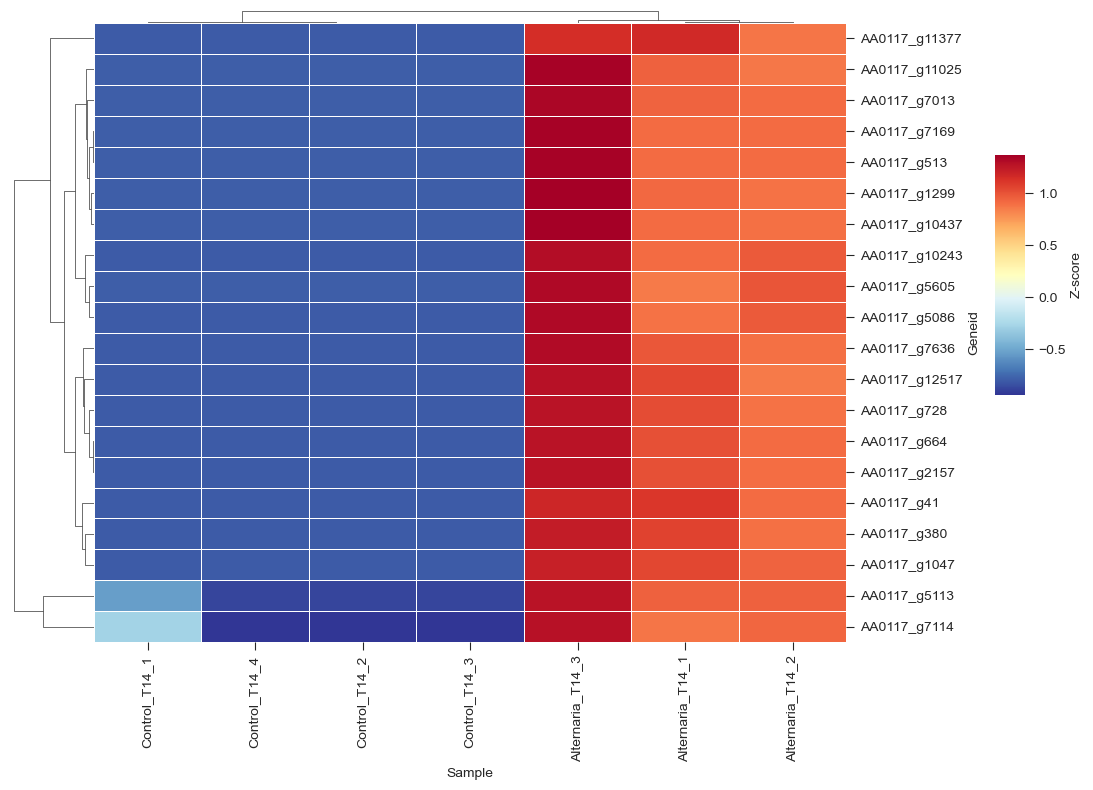

In [42]:
# Create a DataFrame from the log-transformed expression matrix
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

# Select the top 20 most variable genes based on standard deviation
top_genes = grapher.var(axis=1).nlargest(20).index
grapher_top = grapher.loc[top_genes]

# Create a hierarchical clustering heatmap with an aligned color bar
g = sns.clustermap(grapher_top, z_score=0, cmap='RdYlBu_r', figsize=(10, 8),
                   linewidths=0.5, xticklabels=True, yticklabels=True,
                   cbar_pos=(1, 0.5, 0.03, 0.3),  # Aligns color bar to the right
                   dendrogram_ratio=(0.1, 0.02),  # Adjusts dendrogram proportions
                   cbar_kws={'label': 'Z-score'})  # Labels the color bar

plt.savefig('Heatmap_alternaria_14dpi.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [43]:
# Volcano plot

In [44]:
# Define significance thresholds
padj_threshold = 0.01
logFC_threshold = 1.5

In [45]:
# Filter significant results and split
significant_sigs = res[(res['padj'] < padj_threshold) & (abs(res['log2FoldChange']) > logFC_threshold)]
positive_sigs = significant_sigs[significant_sigs['log2FoldChange'] > 0]
negative_sigs = significant_sigs[significant_sigs['log2FoldChange'] < 0]

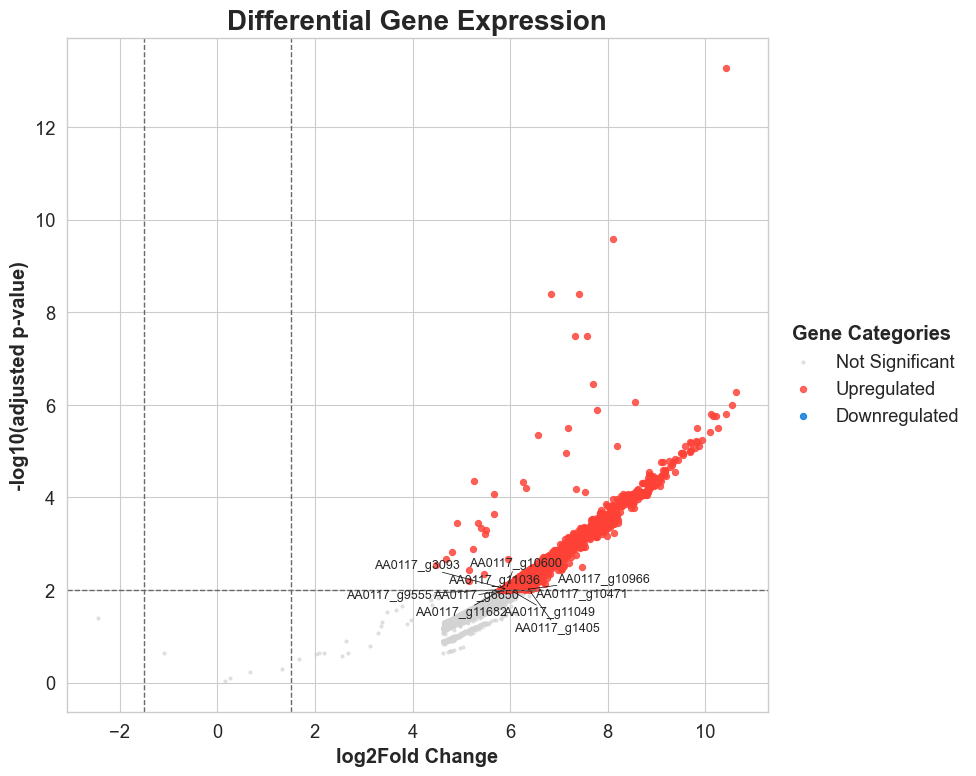

In [46]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Create volcano plot
plt.scatter(res['log2FoldChange'], -np.log10(res['padj']), color='lightgray', alpha=0.6, s=5, label='Not Significant')
plt.scatter(positive_sigs['log2FoldChange'], -np.log10(positive_sigs['padj']), color='#FF4136', alpha=0.8, s=20, label='Upregulated')
plt.scatter(negative_sigs['log2FoldChange'], -np.log10(negative_sigs['padj']), color='#0074D9', alpha=0.8, s=20, label='Downregulated')

# Add threshold lines
plt.axhline(-np.log10(padj_threshold), color='dimgray', linestyle='--', linewidth=1)
plt.axvline(logFC_threshold, color='dimgray', linestyle='--', linewidth=1)
plt.axvline(-logFC_threshold, color='dimgray', linestyle='--', linewidth=1)

# Customize the plot
plt.xlabel('log2Fold Change', fontweight='bold')
plt.ylabel('-log10(adjusted p-value)', fontweight='bold')
plt.title('Differential Gene Expression', fontsize=20, fontweight='bold')

# Add legend
legend = plt.legend(title='Gene Categories', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontweight='bold')

# Label top significant genes
top_genes = significant_sigs.nlargest(10, 'padj')
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), i, fontsize=9))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Adjust layout and save
plt.tight_layout()
plt.savefig('volcano_plot_alternaria_14dpi.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [47]:
# Download Data

In [48]:
res.to_csv('expreesed_genes_alternaria_14dpi.csv')
sigs.to_csv('sigs_expreesed_genes_alternaria_14dpi.csv')